# Rendering Black Holes in Python
- Final Project By Aditya Jain and Jiri Kataman-Kustwan

**Note:** While not benchmarked, you will most likely get a speed boost switching to the GPU instance in colab

**UPDATE:** The code does not seem to work on the CPU at all. This is most likely a bug with `jax.vmap`. Please switch to a GPU instance before running

This project makes heavy reference of a lot of online source material. We would like to thank [James Space Blog](https://20k.github.io/c++/2024/05/31/schwarzschild.html) for direction and motivation behind this work.

In [47]:
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import cv2
from functools import partial

# Overview

Our goal is to visualize one of the more interesting predictions of general relativity: the existence of black holes. We are looking at a bit of a simpler case for this excersize, as we are implementing a sort of self-sustaining curved spacetime without any mass-ful objects inside of it. Our goal is to end up with a black hole that looks something like this (this is called the schwarzchild black hole):
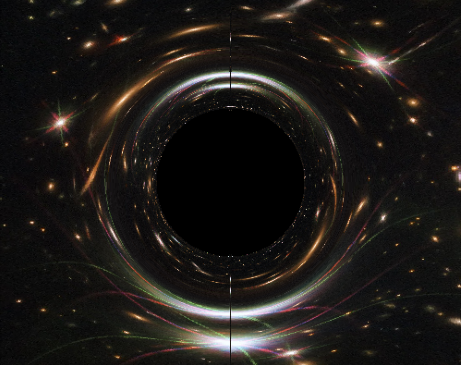

To render our black hole, we use a technique called ray tracing. We simulate the paths of light rays as they interact with the curved spacetime surrounding the black hole. Essentially, we shoot a light ray out of every pixel, and see where it goes. If it goes into the black hole, we avoid rendering it, else we render it.

In general, we need to accomplish 3 (kind of 4) steps to get a rendering system working.

1. Get the initial conditions (direction and position) of the light beam we want to raytrace with
2. Step light through time with some sort of integration scheme (in reverse ... more on this later)
3. Record the final position of our light ray. If it is where our black hole is, we know to render that pixel black ... otherwise we get a pixel from a background texture

Let's download our background image:



In [48]:
!curl "https://science.nasa.gov/wp-content/uploads/2023/04/stsci-h-p1958a-f-2300-jpg.webp" -o image_to_render.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  898k  100  898k    0     0  2514k      0 --:--:-- --:--:-- --:--:-- 2518k


# Part 1: General Relativity Redux

## What is a black hole?
Unintuitively, black holes are not physical objects, despite having a "mass". Specifically, he Schwarzschild black hole we will be rendering belongs to a class of solutions in General Relativity called vacuum solutions, which means there is no matter or energy present within the black hole. Instead, its existence is entirely defined by the warping of spacetime itself.

The thing we end up seeing when "see" a black hole is the warping of light around it. General relativity tells us that spacetime is curved, and as a result, any object travelling through a warped spacetime will "curve" (to us this looks like an external long-handed force like gravity).

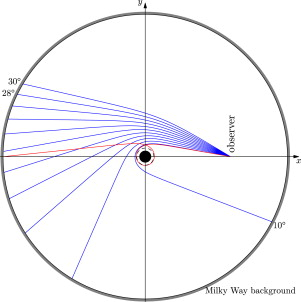

## Geodesics, Curved Spacetimes, and Metric Tensors
When we perform a raytracing operation traditionally, light follows a straight path. Therefore, it generally suffices for most non-relatavistic applications to only track objects that the beam of light reflects off of to determine the final pixel value.

However, due to the curved nature of spacetime, our light ray follows a curved path. Intuitively, this can be thought of as some sort of "acceleration" applied to our light in our reference frame. The path that light takes over spacetime is called the **geodesic**

Mathematically, our geodesic can be represented as the following tensor expression:

$$
a^\mu = -\Gamma^\mu_{\alpha\beta} v^\alpha v^\beta
$$

where $\frac{dx^\mu}{d\lambda} = v^\mu$

The use of $d\lambda$ as our "time" parameter for velocity may be surprising. Recall from special relativity that the notion of time is arbitrary according to our reference frame. This is still true in general relativity So we use $d\lambda$, which can be thought of as a tangent vector to our geodesic (i.e. a directional vector with norm $|\lambda| = 1$).

Now what we need to do is hopefully a bit more clear. We have an equation that lets us get the "acceleration" of our light ray at each position in space. All we need to do now is implement a `Step()` or `integrate()` function that takes our current postion and velocity, calculates our $a^\mu$ by the geodesic equations, and transforms our position and velocity by our $a$.

> Note the use of 4-vectors for our position and velocity vectors. To make our lives easier we use the 4 vector $x = \langle t, r, \theta, \phi\rangle$ (this is called schwarzchild coordinates, but it can also just be thought of as 4-vectors in spherical coordinates). All other 4-vectors like velocity are derived from this
>
> Our black hole is at the center of this coordinate system $r=1$

In [49]:
@jax.jit
def integrate(geodesic_position, geodesic_velocity):
  ## a indicator variable to get our result from our integration
  ## 0 if we dont reach anywhere
  ## 1 if we hit the black hole
  ## 2 if we make it past a certain arbitrary escape radius (10 in this case)
  final = 0
  dt = 0.005
  ## black hole radius
  rs = 1
  start_time = geodesic_position[0]

  i = 0
  MAX_STEPS = 100000

  def condition(state):
    p, v, f, i = state
    return (i < MAX_STEPS) & (f == 0)

  def Step(state):
    p, v, f, i = state
    acceleration = GetAcceleration(p, v)

    p = p + v * dt
    v = v + acceleration * dt

    ## escape condition
    f = jax.lax.select((p[1] > 10) | (f == 2), 2, f)

    ## ray is very close to the black hole or has been in the same position for a long time means it has hit the event horizon
    f = jax.lax.select((((p[1] < rs + 0.0001) | (p[0] > start_time + 1000)) & (f != 2)) | (f==1), 1, f)

    return p, v, f, i+1

  p, v, f, _ = jax.lax.while_loop(condition, Step, (geodesic_position, geodesic_velocity, final, i))

  return f, p, v

As a small note, we use euler instead of RK4 due to the computational complexity in calculating `GetAcceleration` several times per step, we have not benchmarked this, but it is on the order of 2x from our visual observations

### A Quick Tangent on JAX
While the integrator above looks familiar (it is the same as the one from Orbital Dynamics), it dosent look like a normal python integrator. That is because this project is far to computationally expensive to do with just numpy and python. In our attempts to do the project without the use of any accelerators, it took us 5 hours to render a single image of size 100x80.

Luckilly, we have plenty of linear algebra accelerators available to us in python. One such accelerator is JAX, which has a few key properties that makes it useful to us

- **XLA compilation**. With `jax.jit()`, we can compile any self-contained piece of python code to XLA, which is a compute language designed to run directly on CPU/GPU/TPU.
- **Automatic Differentiation**. Later on, we will need to take partial derivatives of some moderately computationally heavy functions. A tradtional fixed-point method would make several calls to this function, which is not what we want ideally. With `jax.grad()` and `jax.jacobian()` we can precompute any derivative functions with automatic differentiation.
- **Vectorization**. Rendering an image via raytracing is an easilly parrelelizable task. More precisely, due to the massless nature of light, each light ray does not change or interfere with any other light ray during our raytracing. So ideally, we want to be able to step through all the light rays in parallel. `jax.vmap()` lets us do that with minimal modifications to our code.
- **Drop in Numpy support**. Using JAX is also quite easy, all we have to do is replace any `np.*()` with `jnp.*()` as most functions in numpy have a [direct one-to-one implementation in JAX](https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html).

Utilizing JAX, we are able to turn a 5 hour render into a 30 second one.

All of our code will be written in JAX from here on out.

## Calculating Our Acceleration

Now all we have left to get a working `GetAcceleration()` function is to figure out how to calculate it. Particularly, we are missing $-\Gamma^\mu_{\alpha\beta}$. This is called the **christoffel symbol**, and is essentially a representation of the curvature of our spacetime. We can calculate it as follows.

$$
\Gamma^\mu_{\alpha\beta} = \frac{1}{2} g^{\mu\sigma} (\partial_\beta g_{\sigma\alpha} + \partial_\alpha g_{\sigma\beta} - \partial_\sigma g_{\alpha\beta})
$$

where $g^{\mu\sigma}$ is our metric tensor.

### Metric Tensors in General Relativity
As in special relativity, our metric tensor is a representation of distance, except now adapted for curved spacetime. As such, our metric tensor depends on our position in spacetime.

The metric tensor for a schwarzchild black hole is given as follows

$$
g = g_{\mu\nu} = \begin{pmatrix}
- \left(1 - \frac{r_s}{r}\right) & 0 & 0 & 0 \\
0 & \left(1 - \frac{r_s}{r}\right)^{-1} & 0 & 0 \\
0 & 0 & r^2 & 0 \\
0 & 0 & 0 & r^2 \sin^2\theta
\end{pmatrix}
$$

Confusingly, $r_s$ is the radius of our black hole (which we set to $r_s = 1$), and $r$ is our radial position coordinate ($x^1$ in our 4-vector).

Putting it all together, we get

In [50]:
@jax.jit
# Acceleration function
def GetAcceleration(position, velocity):
    christoff = GetChristoffSymbols(position)
    acceleration = jnp.empty(4)

    ## where is np.einsumeasy()??
    for mu in range(4):
        sum = 0
        for alpha in range(4):
            for beta in range(4):
                sum += -christoff[mu, alpha, beta] * velocity[alpha] * velocity[beta]

        acceleration = acceleration.at[mu].set(sum)
    return acceleration

def GetChristoffSymbols(position):
  metric = GetSchwarzchildMetric(position)
  metric_inverse = jnp.linalg.inv(metric)
  ## We dont want the full jacobian but only the diagonal differentials
  metric_diff = jnp.transpose(GetSchwarzchildDifferential(position))

  gamma = jnp.zeros((4, 4, 4))
  for mu in range(4):
      for alpha in range(4):
          for beta in range(alpha, 4):
              sum = 0
              for sigma in range(4):
                  sum += 0.5 * metric_inverse[mu, sigma] * (metric_diff[beta, sigma, alpha] + metric_diff[alpha, sigma, beta] - metric_diff[sigma, alpha, beta])
              gamma = gamma.at[mu, alpha, beta].set(sum)
              gamma = gamma.at[mu, beta, alpha].set(sum)

  return gamma

def GetSchwarzchildMetric(position):
  rs = 1.0
  r = position[1]
  theta = position[2]

  metric_diag = jnp.array([-(1 - rs / r), 1 / (1 - rs / r), r * r, r * r * jnp.sin(theta)**2])

  return jnp.diag(metric_diag)

GetSchwarzchildDifferential = jax.jacobian(GetSchwarzchildMetric)

Our way of summing einstein notation is rather crude, but there was little speedup in using `einsum`, which was not only confusing but hard to read and debug.

Also notice the exploitation of symmetry in the christoff symbol calculation, christoff symbols are symmetric matricies, so we can perform effectively half the normal calculations

# Part 2: Initial Conditions

Now that we have gotten through the `integrate` function, we have to figure out our initial conditions. In particular, we need a position and velocity.

Let us define our initial position $x_0$ for our light rays to be a point camera at ... lets say $x_0^\mu = \langle 0, 8, \frac{\pi}{2}, -\frac{\pi}{2}\rangle$.

To get our $v^\mu_0$, we just need an initial directional vector $\lambda$. As we are shooting a light ray from a supposed pixel, a logical first instinct for $\lambda$ would be the distance from the pixel to the origin. It is relatively confusing to convert pixel distances to "real" distances, but luckily $|\lambda| = 1$ so we don't actually need to.

In [51]:
def GetDirectionThroughPixel(sx, sy, screen_width, screen_height, fov_degrees):
  fov_rad = jnp.deg2rad(fov_degrees)
  f_stop = (screen_width / 2) / jnp.tan(fov_rad / 2)

  direction = jnp.array([sx - screen_width / 2, sy - screen_height / 2, f_stop])

  return direction / jnp.linalg.norm(direction)

### Tetrads

There is an obvious problem to our current approach. Our $x^\mu$ and $v^\mu$ are in the reference frame relative to the camera, and need to be transformed to the perspective of an external stationary observer of spacetime, which is the perspective we are interested in viewing our black hole from.

To do this, we introduce a new set of basis vectors called tetrads, which transform our reference frame to a different one at a given point.

There is a [lot more to say](https://en.wikipedia.org/wiki/Tetrad_formalism) about tetrads involving locally flat spacetimes and tangent planes. For our case we have [precomputed tetrads](https://www2.mpia-hd.mpg.de/homes/tmueller/pdfs/catalogue_2014-05-21.pdf) given for Schwarzchild spacetime as:


**Time component $t$:**
$$
e_t = \langle \frac{1}{\sqrt{1 - \frac{r_s}{r}}}, 0, 0, 0 \rangle
$$

**Radial component $r$:**
$$
e_r = \langle 0, \sqrt{1 - \frac{r_s}{r}}, 0, 0 \rangle
$$

**Polar component $\theta$:**
$$
e_\theta = \langle 0, 0, \frac{1}{r}, 0 \rangle
$$

**Azimuthal component $\phi$:**
$$
e_\phi = \langle 0, 0, 0, \frac{1}{r\sin\theta}\rangle
$$

Our initial position $x^\mu$ and velocity $v^\mu$ that we feed into our `integrate()` function is then

$$x^\mu = e_i^\mu x^i$$
$$v^\mu = e_i^\mu v^i$$

In [52]:
def GetSchwarzchildTetrad(position):
  rs = 1
  r = position[1]
  theta = position[2]

  et = jnp.array([1 / jnp.sqrt(1 - rs / r), 0, 0, 0])
  er = jnp.array([0, jnp.sqrt(1 - rs / r), 0, 0])
  etheta = jnp.array([0, 0, 1 / r, 0])
  ephi = jnp.array([0, 0, 0, 1 / (r * jnp.sin(theta))])

  return et, er, etheta, ephi

def DotTetrad(position, direction, tetrad):
  velocity = -1 * tetrad[0] + tetrad[1] * direction[0] + tetrad[2] * direction[1] + tetrad[3] * direction[2] # 4 vector inner product of direction and tetrad
  return position, velocity

@jax.jit
def GetInitialConditions(x, y, screen_width, screen_height):
  ray_dir = GetDirectionThroughPixel(x, y, screen_width, screen_height, 90)
  camera = jnp.array([0, 8, jnp.pi/2, -jnp.pi/2])
  tetrad = GetSchwarzchildTetrad(camera)

  ray_dir = jnp.array([-ray_dir[2], ray_dir[1], ray_dir[0]])  # Reverse direction along z-axis
  g_pos, g_vel = DotTetrad(camera, ray_dir, tetrad)

  return g_pos, g_vel

# Part 3: Getting Final Positions and Putting It Together

Now that we have initial conditions and a `Step` function, all we need to do is render the image based on our final state.

As a reminder:
- If we hit the black hole, we render no pixel
- If we dodge the black hole, we use some more trig to figure out what pixel of the background image to render

Both of these are much more straightforward to implement.

In [53]:
# We tell jax to recompile this function to XLA every time integrate changes to allow for
# Easy updates to our spacetime equations
@partial(jax.jit, static_argnames=['integrate'])
def render_coordinate(x, y, screen_width, screen_height, image, integrate):
  g_pos, g_vel = GetInitialConditions(x, y, screen_width, screen_height)

  result, g_pos, g_vel = integrate(g_pos, g_vel)
  # result2, , g_vel = integrateRK4(g_pos, g_vel)
  x, y = GetTexturePixelFromAngle(g_pos[2], g_pos[3])

  ## Looparound hack
  im_x = (x * image.shape[0]).astype(int) % image.shape[0]
  im_y = ((y * image.shape[1]).astype(int) + image.shape[1]) % image.shape[1]

  ## return pixel color depending on result
  return jnp.where(result != 2, jnp.array([0, 0, 0]), image[im_x, im_y])

def GetTexturePixelFromAngle(theta, phi):
    theta = jnp.fmod(theta, 2 * jnp.pi)

    # Adjust theta and phi based on the condition using jnp.where (no explicit if)
    adjustment = (theta >= jnp.pi) * jnp.pi
    phi = phi + adjustment
    theta = theta - adjustment

    phi = jnp.fmod(phi, 2 * jnp.pi)

    x = phi / (2 * jnp.pi)
    y = theta / jnp.pi

    x = x + 0.5

    return x, y

## Adding Parallization
Now this is where the magic of JAX really comes into play. We can run each pixel in parallel with a simple `jax.vmap()`!

In [54]:
render_coordinate_vmap = jax.vmap(render_coordinate, in_axes=[0, 0, None, None, None, None])

## Final code

Our entry function then looks like this

In [55]:
def render_image(screen_width, screen_height, integrate=integrate):
    # Generate pixel coordinates
    x_coords = jnp.linspace(0, screen_width - 1, screen_width)
    y_coords = jnp.linspace(0, screen_height - 1, screen_height)

    # Create a meshgrid of pixel coordinates (sx, sy)
    grid_x, grid_y = jnp.meshgrid(x_coords, y_coords)

    # Flatten the grid for vectorized processing
    flat_x = grid_x.flatten()
    flat_y = grid_y.flatten()

    ## Cool background
    background = jnp.array(cv2.resize(plt.imread('/content/image_to_render.jpg'), (screen_width*2, screen_height*2)))
    # Use vmap to process all pixels simultaneously
    rendered_image = render_coordinate_vmap(flat_x, flat_y, screen_width, screen_height, background, integrate)

    # Reshape the output to match the image size (500x400 pixels)
    return rendered_image.reshape(screen_height, screen_width, 3)  # Assuming the color channels are RGB

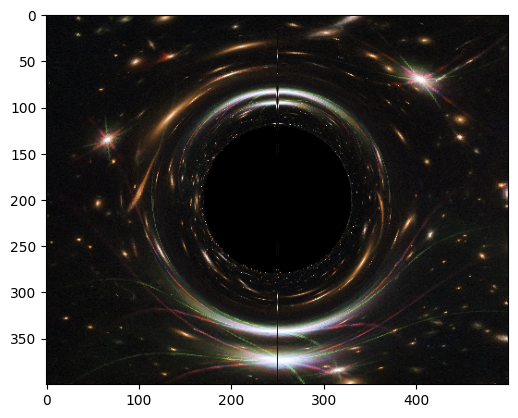

In [56]:
screen_width = 500
screen_height = 400
rendered_image = render_image(screen_width, screen_height)

plt.imshow(rendered_image)
plt.show()

# EXTRA: Fixing polar singularities with dynamic timestepping

Notice the ugly lines at the polar angles of the black hole? This is a numerical bug in our `integrate` function. Specifically, we are using a discrete `dt` as an approximation for a continuous one, so we lose some accuracy around high acceleration points, namely the poles.

Luckily, this is a pretty easy fix: we just lower our `dt` if we get really close to the poles. This will make our code run slightly slower, but the poles will be gone

In [57]:
def integrate(geodesic_position, geodesic_velocity):
  ## a indicator variable to get our result from our integration
  ## 0 if we dont reach anywhere
  ## 1 if we hit the black hole
  ## 2 if we make it past a certain arbitrary escape radius (10 in this case)
  final = 0

  # We no longer want a fixed dt
  # dt = 0.005
  dt_far = 0.005
  dt_close = 0.002
  precision_radius = 3

  ## black hole radius
  rs = 1
  start_time = geodesic_position[0]

  i = 0
  MAX_STEPS = 100000

  def condition(state):
    p, v, f, i = state
    return (i < MAX_STEPS) & (f == 0)

  def Step(state):
    p, v, f, i = state
    acceleration = GetAcceleration(p, v)

    ## pick our precise dt if we are near poles
    dt = jax.lax.select(jnp.abs(p[1]) < precision_radius,
                        dt_close,
                        dt_far)

    p = p + v * dt
    v = v + acceleration * dt

    ## escape condition
    f = jax.lax.select((p[1] > 10) | (f == 2), 2, f)

    ## ray is very close to the black hole or has been in the same position for a long time means it has hit the event horizon
    f = jax.lax.select((((p[1] < rs + 0.0001) | (p[0] > start_time + 1000)) & (f != 2)) | (f==1), 1, f)

    return p, v, f, i+1

  p, v, f, _ = jax.lax.while_loop(condition, Step, (geodesic_position, geodesic_velocity, final, i))

  return f, p, v

Now that we have updated our `integrate` function, lets rerun our renderer. We should see the polar singularities gone.

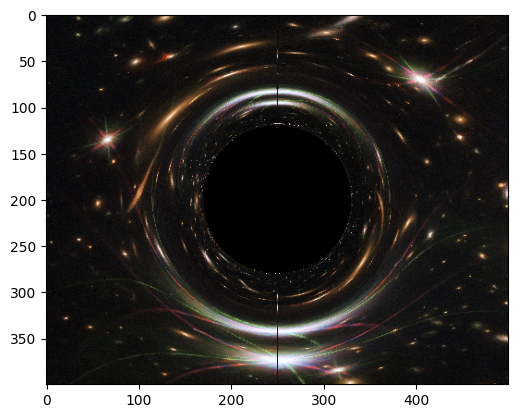

In [58]:
screen_width = 500
screen_height = 400
rendered_image = render_image(screen_width, screen_height, integrate)

plt.imshow(rendered_image)
plt.show()